In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

import importlib
import ztf_utils
importlib.reload(ztf_utils)
import ztf_utils
import base64
import gzip
import io
from tqdm import tqdm
from scipy import stats

In [8]:
data_path = "/home/rcarrasco/stamp_classifier/pickles/alerts_for_training.pkl"
data = pd.read_pickle(data_path)

### Using asteroids for cleaner background (?)

In [9]:
data.head()

,class,oid,cutoutScience,cutoutTemplate,cutoutDifference
0,asteroid,ZTF19aaqbejc,b'\x1f\x8b\x08\x00/a\xb1\\\x02\x03\xed\xbbU\x9...,b'\x1f\x8b\x08\x00/a\xb1\\\x02\x03\xed\x9bU\xb...,b'\x1f\x8b\x08\x00/a\xb1\\\x02\x03\xed\xb7iX\x...
1,asteroid,ZTF18abtzgzv,b'\x1f\x8b\x08\x00oO\x92[\x02\x03\xed\xbaU\xb8...,b'\x1f\x8b\x08\x00oO\x92[\x02\x03\xed\xbbU\x94...,b'\x1f\x8b\x08\x00oO\x92[\x02\x03\xed\xb7i8Wo\...
2,asteroid,ZTF18aczukeo,b'\x1f\x8b\x08\x00\xed \x1e\\\x02\x03\xed\xbbo...,b'\x1f\x8b\x08\x00\xed \x1e\\\x02\x03\xed\x9ae...,b'\x1f\x8b\x08\x00\xed \x1e\\\x02\x03\xed\xd7i...
3,asteroid,ZTF18acbwedc,b'\x1f\x8b\x08\x00\xa0\x9f\xd9[\x02\x03\xed\xb...,b'\x1f\x8b\x08\x00\xa0\x9f\xd9[\x02\x03\xed\x9...,b'\x1f\x8b\x08\x00\xa0\x9f\xd9[\x02\x03\xed\xb...
4,asteroid,ZTF19aaewcjj,b'\x1f\x8b\x08\x00\xc35M\\\x02\x03\xed\xbb}|\x...,b'\x1f\x8b\x08\x00\xc35M\\\x02\x03\xed\x9beTUm...,b'\x1f\x8b\x08\x00\xc35M\\\x02\x03\xed\xb7i4Wo...


In [10]:
asteroids = data[data["class"]=="asteroid"]

## Extracting sources and background level

In [12]:
science_images = []
clipped_images = []
background_est = []
background_images = []
print("n asteroids", len(asteroids))
for i in range(len(asteroids)):
    stamp = ztf_utils.bin2array(asteroids["cutoutScience"][i])
    if np.isnan(stamp).any():
        continue
    science_images.append(stamp)
    clipped_im, bck = ztf_utils.image_sigma_clip(stamp, poisson_noise=False)
    clipped_images.append(clipped_im)
    background_est.append(bck)
    background_images.append(clipped_im - bck)

n asteroids 1235


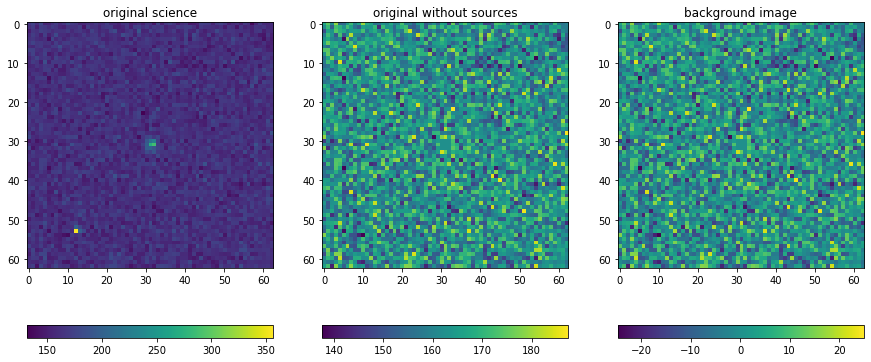

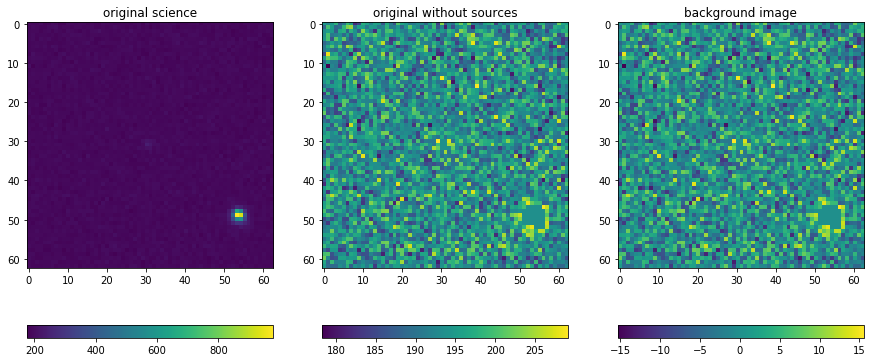

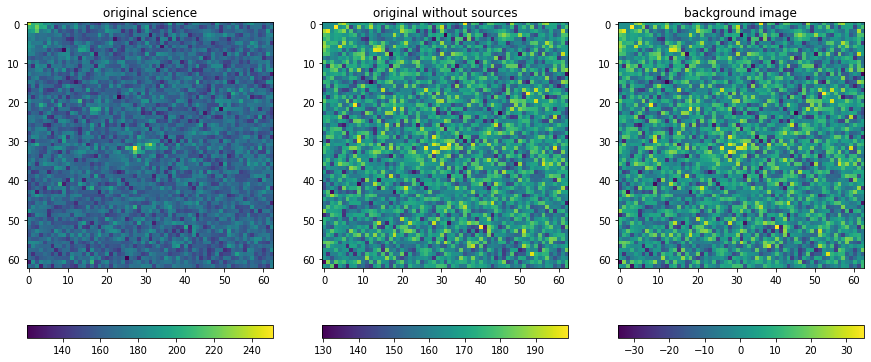

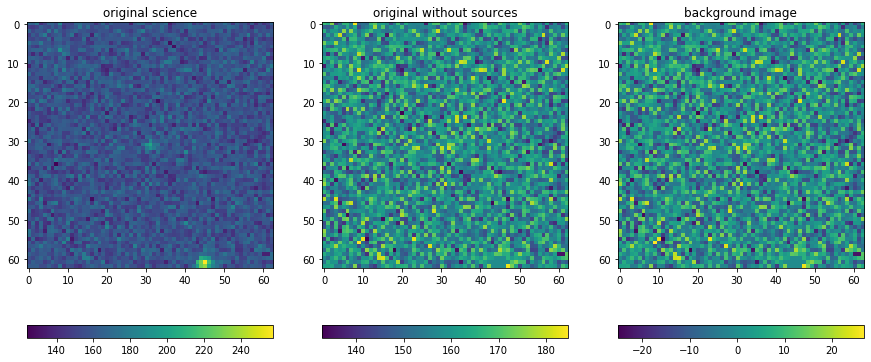

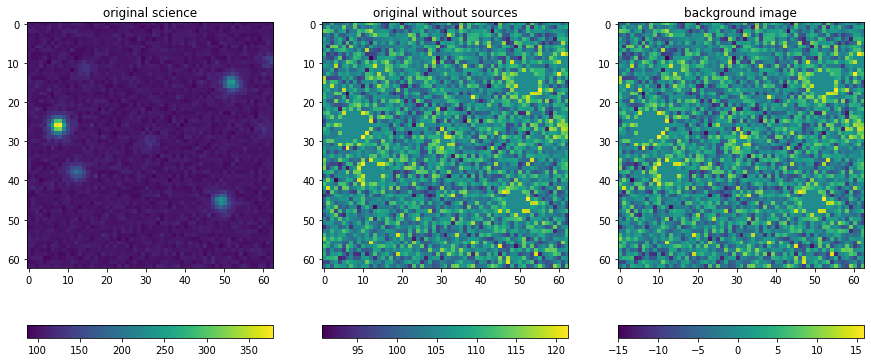

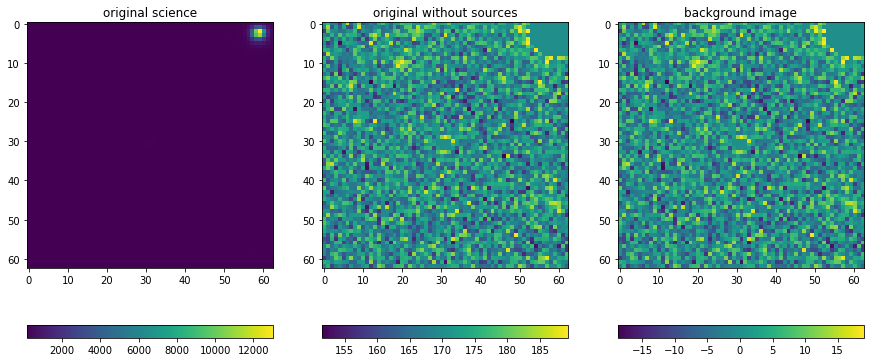

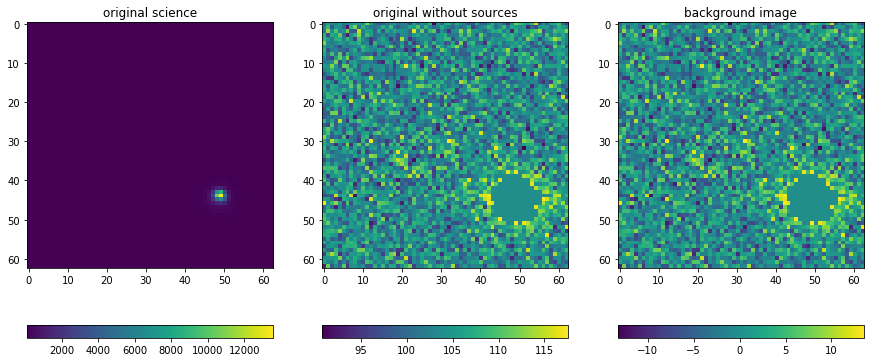

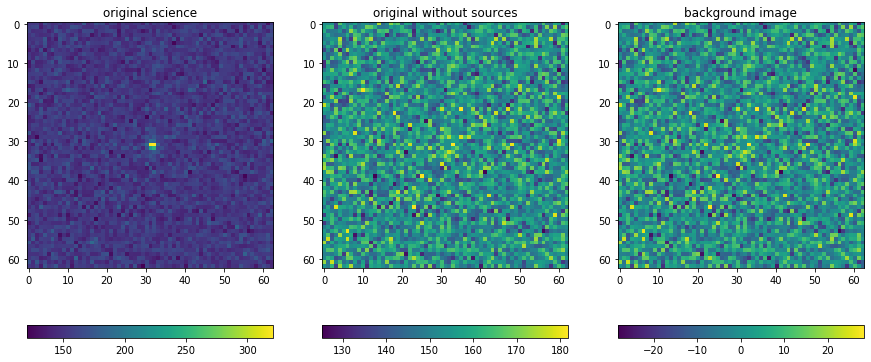

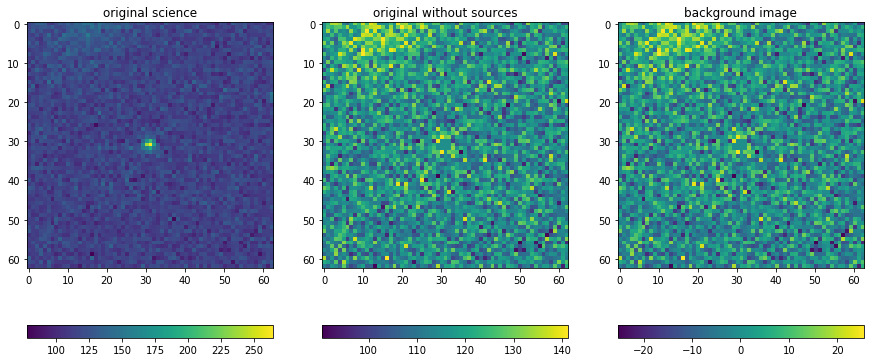

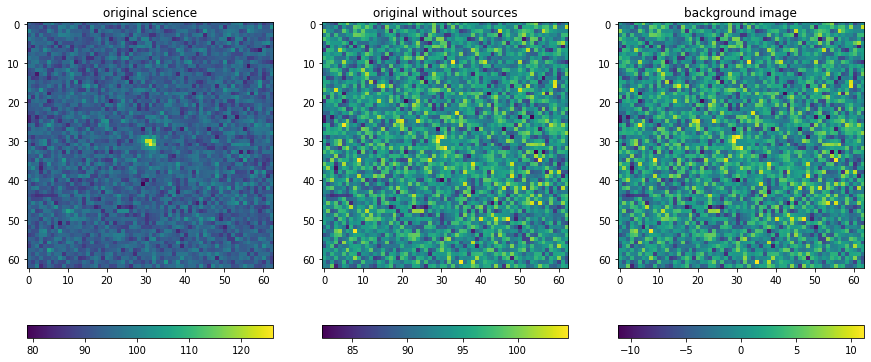

In [13]:
for i in range(10):
    f, ax = plt.subplots(1, 3, figsize=(15, 7))
    im1 = ax[0].imshow(science_images[i])
    im2 = ax[1].imshow(clipped_images[i])
    im3 = ax[2].imshow(background_images[i])
    ax[0].set_title("original science")
    ax[1].set_title("original without sources")
    ax[2].set_title("background image")
    f.colorbar(im1, ax=ax[0], orientation='horizontal')
    f.colorbar(im2, ax=ax[1], orientation='horizontal')
    f.colorbar(im3, ax=ax[2], orientation='horizontal')
    plt.show()

## Photometry in random places within the background noise

In [14]:
radius = [2, 3, 5, 10, 15, 20]

counts_per_r = []
for r in radius:
    phot = ztf_utils.run_background_photometry(background_images,
                                              appertures_per_stamp=10,
                                              radius=r,
                                              do_plots=False,
                                              return_masked=False)
    counts_per_r.append(phot)

/home/rcarrasco/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rcarrasco/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rcarrasco/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[]

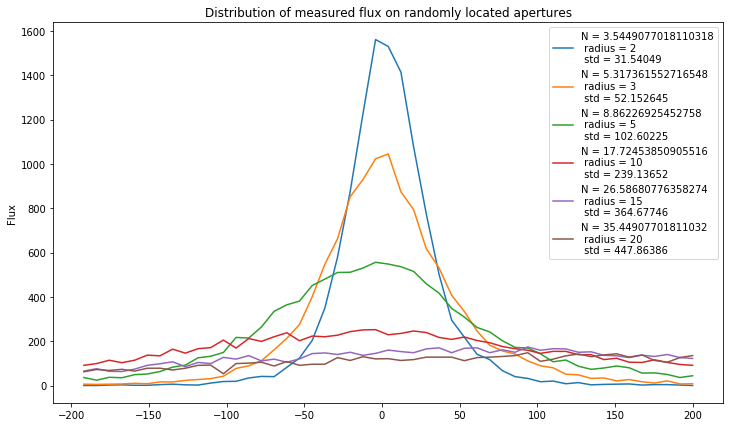

In [15]:
bins = np.linspace(-200, 200, num=50)
plt.figure(figsize=(12,7))
for i, counts in enumerate(counts_per_r):
    hist, _ = np.histogram(counts, bins=bins)
    counts_std = np.std(counts)
    n = np.sqrt(np.pi*radius[i]**2)
    plt.plot(bins[1:], hist, label="N = "+str(n)+"\n radius = "+str(radius[i])+" \n std = "+str(counts_std))
plt.title("Distribution of measured flux on randomly located apertures")
plt.ylabel("Flux")
plt.legend()
plt.plot()

We model the uncertainties to be proportional to the number of pixels of the aperture to a given power $\beta$:

$\sigma_{N} = \sigma_{1}\alpha N^{\beta}$

where $N$ is the effective size of the aperture $(N =
\sqrt{n_{pix}}$)

In [17]:
N = np.arange(30) + 1
radius = N/np.sqrt(np.pi)

sigma = []

for r in tqdm(radius, total=len(radius)):
    phot = ztf_utils.run_background_photometry(background_images,
                                              appertures_per_stamp=10,
                                              radius=r,
                                              do_plots=False,
                                              return_masked=False)
    sigma.append(np.std(phot))
    

100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


NameError: name 'alpha' is not defined

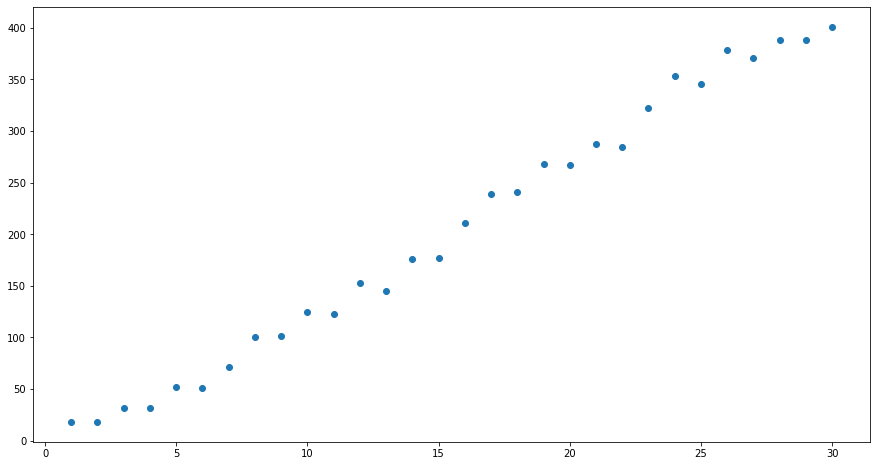

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(N, sigma, "o", label="Observations")
plt.plot(N, N, label="to N")
plt.plot(N, alpha*sigma1*N**2, label="to N**2")
plt.legend()
plt.title("Background fluctuations as a function of aperture size in ZTF images")
plt.show()

18.101824 0.5491738559579691 1.0883706656665


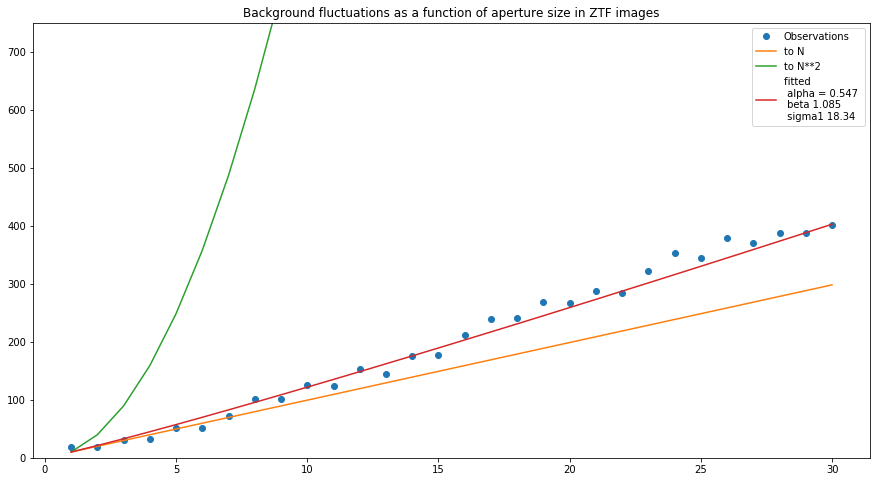

In [22]:
sigma1 = sigma[0]
x = np.log(N)
y = np.log(sigma)
m, n, r_value, p_value, std_err = stats.linregress(x,y)

alpha = np.exp(n - np.log(sigma1))
beta = m

print(sigma1, alpha, beta)

fitted_curve = sigma1*alpha*np.power(N, beta)

plt.figure(figsize=(15, 8))
plt.plot(N, sigma, "o", label="Observations")
plt.plot(N, alpha*sigma1*N, label="to N")
plt.plot(N, alpha*sigma1*N**2, label="to N**2")
plt.ylim([0, 750])
plt.plot(N, fitted_curve, label="fitted \n alpha = 0.547 \n beta 1.085 \n sigma1 18.34")
plt.legend()
plt.title("Background fluctuations as a function of aperture size in ZTF images")
plt.show()

In [ ]:

m, n, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x, y, "o", label="data")
plt.plot(x, x*m + n, label="fit")
plt.legend()
plt.show()